In [1]:
# MIT License
#
#@title Copyright (c) 2021 CCAI Community Authors { display-mode: "form" }
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# **Tutorial on Building Fast Emulators in Climate Modeling**

**ATM S 559 2024 is using this code written and provided by the authors below. CMB made some minor modifications mainly to the comments and markdown blocks to use the language of climate modelers and so the code can be run on Casper/Derecho with the intended data that CMB download for you. Also CMB has added some additional visualization and questions for you to address in your write up. Search the code for ATMS559 to find the questions.** 

**The point of this code is to construct an emulator that is intended to emulate the climate response to climate forcing - not the internal climate variability. This code does not actually apply any machine learning other than polynomial fitting. The rest of this introductory statement is by the original authors.**

Author:

*   Björn Lütjens, MIT EAPS, lutjens@mit.edu

Co-Authors:
*   Lea M. Hadzic, Stanford University
*   Mark Veillette, MIT Lincoln Laboratory
*   Duncan Watson-Parris, UC San Diego
*   Dava Newman, MIT Media Lab
*   Raffaele Ferrari, MIT EAPS
*   Noelle Selin, MIT IDSS

Climate models are essential in policy making. Ideally, policy makers would like to interact with climate models through quick 'what-if' questions. For example, 'what-if we plant one trillion trees' or 'what if we support carbon tax'. However, current climate models need supercomputers and are overall too impractical to give quick answers. The below TEDx video goes into more detail. 

This tutorial will teach machine learning (ML) practitioners and Earth scientists about a possible solution: fast approximations of climate models. We call those approximations 'emulators'. ML emulators have generated weather forecasts in seconds rather than hours (Lam et al., 2023), but their usefulness in climate is still unclear. For the ML community, we introduce the in-/output dimensions, how to access data, the strength of a linear baseline, and common evaluation protocols for getting started with climate emulation. For the Earth scientist, we highlight key learnings in picking the functional form that ML shall learn, the need for non-ML baselines, and the risk of overfitting to internal variability.

The original software is from [github.com/blutjens/climate-emulator-tutorial](https://github.com/blutjens/climate-emulator-tutorial)

The modified version for our class is at [github.com/cmbitz/ATMS559-climate-emulator-tutorial](https://github.com/cmbitz/ATMS559-climate-emulator-tutorial)

The lead author has a TEDx talk that is interesting but not that relevant to this exercise.
*How Machine Learning can Empower Local Climate Voices* | Björn Lütjens | TEDxBoston
[Watch on YouTube](https://www.youtube.com/watch?v=DTX8SvdtrmU)

## Table of Contents

*   [Introduction](#Introduction)
    *   [Climate Impact](#Climate-Impact:-Emulators-empower-local-climate-voices)
    *   [Target Audience, Background, and Prerequisites](#Target-Audience,-Background,-and-Prerequisites)
    *   [Installation](#Installation)
*   [Data](#Data)
    *   [Data Description](#Data-Description)
    *   [Data Download](#Data-Download)
    *   [Data Preprocessing](#data-processing)
    *   [Selecting the in- and output variables](#inputs-and-outputs)
    *   [Data Visualization](#Data-Visualization)
*   [Constructing the linear emulators](#methodology)
    *   [Global CO2 to T](#linear-co2-to-tas)   
    *   [Linear Pattern Scaling Emulator: Global T to local T](#global-to-local-tas)   
*   [Results & Discussion](#results-and-discussion)
    *   [Evaluating Climate Emulators](#Evaluating-Climate-Emulators)
    *   [CNN-LSTM: Comparison with a large deep learning model](#cnn-lstm)
    *   [Data vs. model complexity: Polynomial Pattern Scaling](#polynomial-pattern-scaling)
*   [Conclusion](#conclusion)
    *   [Summary](#Summary) 
*   [References](#references)


# Introduction

## Target Audience, Background, and Prerequisites

This tutorial as distributed by the original authors was primarily intended for data scientists that are interested in climate modeling. CMB changed it to be more approachable for climate scientists.

## Installation

By now you probably have already cloned the remote repository that contains this code to your local repository. You only need to do this once! If you haven't, then you are probably reading this file on the GitHub repository. Go back to the README.md file on GitHub and follow the Installation instructions there. I'ver repeated the instructions from the README.md FYI 

You will need to install the code from a Terminal on NCAR's system, either Casper or Derecho. To get to a Terminal, go to the + tab at the top of this section on Jupyter Hub desktop, then find the Terminal icon and click it. 

I recommend putting this code either in your home or work space on NCAR's computes. For example, if you want to use your work directory (like I do below) first go to that directory using the cd command from the Terminal and then issue the git clone command as follows: 

cd /glade/work/$USER \
git clone https://github.com:cmbitz/ATMS559-climate-emulator-tutorial.git 

Next you need to create an environment to run this code. If you want to use your own conda or miniconda install, skip the module load conda step. The conda and pip commands create the environment. You'll know it works if at the end you see emcli in the list of environments and if when you open a notebook on on NCAR's Juypter Hub and see the emcli kernel as an option when you go to change the kernel. If that doesn't happen, let Cecilia know right away. 
Thanks!

Be sure to be in your ATMS559-climate-emulator-tutorial directory and be patient while you issue each command one at a time. Say "y" when asked. 

cd /glade/work/$USER/ATMS559-climate-emulator-tutorial \
module load conda \
conda create --name emcli \
conda activate emcli\
pip install -r requirements.txt \
pip install -e . \
python -m ipykernel install --user --name=emcli \
conda env list

At this point when you have this notebook open you can select the correct Kernel by going to Kernel > Change kernel... and selecting *emcli* from the list

FYI here is a list of some of the code you installed 
*   `torch`- Deep learning library
*   `xarray`- Wrapper around numpy to have labeled arrays. Standard for climate data.
*   `netcdf`- Data storage format of most climate data
*   `cartopy` - Geospatial plotting
*   `emcli` - Codebase on climate emulators developed for this tutorial

In [2]:
# Import all modules

# Data visualization
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.colors as colors

# Data manipulation
import pandas as pd
import numpy as np
import xarray as xr


In [3]:
path_climatebench_data = '/glade/derecho/scratch/bitz/rawclimatebench/'  # the raw data that CMB acquired for the class
data_root = './'  # your local data
repo_root = './'  # your local repository where you cloned from GitHub

# Data

## Data Description

There exist much climate data. Indeed the CMIP6 dataset contains over 20 petabyte (PB) of data from over 50 climate models (Tebaldi et al., 2021). The CMIP6 dataset is the primary source for synthesizing climate information to policy and decisionmakers as part of the [IPCC AR6 Report](https://www.ipcc.ch/). Each climate model uses as input a prescribed trajectory of co2, methane, and aerosol emissions, which are called shared socioeconomic pathways (SSPs) (O'Neill et al., 2022). Given one scenario, the climate model then solves many differential equations of the atmosphere, ocean, land, and ice on a supercomputer to predict the climate from 1850 to 2100 and outputs a 3D grid of state variables, such as temperature, wind, pressure, and humidity. 

## Data Download

We leverage the [ClimateBenchv1.0 dataset](https://doi.org/10.1029/2021MS002954), which is a benchmark dataset for emulation of climate variables derived from a full complexity Earth System Model, and slightly modify it (Watson-Parris et al., 2022). The ClimateBench data was assembled to study the impact of greenhouse gases (GHGs) and aerosols onto temperature and precipitation. All data in ClimateBench comes from only a single model (NorESM2) within the CMIP6 dataset.

## Data Preprocessing <a name="data-processing"></a>

ClimateBench contains surface temperature, precipitation, extreme precipitation, and diurnal temperature range (all as 2D fields) and four greenhouse gases emissisons (co2, ch4, bc, and so2) from five climate scenario simulations. 

All ClimateBench data are anomalies (even the GHG emissions), which are departures from a long-term mean of a pre-industrial simulations. They are also annually averaged. The spatial domain is 144 x 96 (lon x lat).

Three scenarios of the past (hist-GHG, hist-aer, and historical) containing data from 1850-2014 and four scenarios of the future (ssp126, -245, -370, and -585) have data from 2015-2100. We'll stack the future with historical data to contain all years from 1850–2100. The data in each scenario is averaged across three realizations; each realization has the same forcings, but slightly different initial conditions. 

The scenarios are detailed in [ClimateBench Table 1](https://doi.org/10.1029/2021MS002954). We hold out one scenario from the 'middle range' (ssp245) for testing and train on the other five to evaluate if a learned model can replicate the NorESM2 ClimateBench data. 

This section formats the raw data into a CO2 -> temp mapping.

In [4]:
#@title code: load ClimateBench training data
from emcli.dataset.climatebench import load_climatebench_data


scenarios_train = ['ssp126','ssp370','ssp585','hist-GHG','hist-aer'] 
len_historical = 165
data_path = path_climatebench_data + '/'

X_train, Y_train = load_climatebench_data(
  simus=scenarios_train, len_historical=0, 
  data_path=data_path)

FrozenMappingWarningOnValuesAccess({'time': 86, 'longitude': 144, 'latitude': 96}) ssp126
FrozenMappingWarningOnValuesAccess({'time': 86, 'longitude': 144, 'latitude': 96}) ssp370
FrozenMappingWarningOnValuesAccess({'time': 86, 'longitude': 144, 'latitude': 96}) ssp585
FrozenMappingWarningOnValuesAccess({'time': 165, 'longitude': 144, 'latitude': 96}) hist-GHG
FrozenMappingWarningOnValuesAccess({'time': 165, 'longitude': 144, 'latitude': 96}) hist-aer


In [5]:
#@title code: Load test data

scenarios_test = ['ssp245']

X_test, Y_test = load_climatebench_data(
  simus=scenarios_test, 
  len_historical=len_historical, 
  data_path=data_path,
  avg_over_ensemble=True)


FrozenMappingWarningOnValuesAccess({'time': 251, 'longitude': 144, 'latitude': 96}) ssp245


We have loaded input data into X_train and output data into Y_train, each a vector of Xarray DataSets
where the vector's elements are the scenarios

We have also input X_test and Y_test. The [train and test teminology is standard for machine learning](https://en.wikipedia.org/wiki/Training,_validation,_and_test_data_sets) (including linear regression). Validation will be explained below. 

Inputs are predictors and outputs are predictands (called learning targets below) of the emulation models that we will explore. At this stage these Xarray DataSets have more variables than we want for a given attempt at emulation. Below we'll select the specific variables from which we will build our emulators. Before we do, we'll explore the data format a bit. Go ahead and do more poking around on your own here if you are unfamiliar with Xarray DataSets

In [6]:
print('Input', X_train[0].data_vars)
print('Output', Y_train[0].data_vars)
print('Training set, number of scenarios: \t\t', len(X_train))
print('Total number of training samples/years: \t', sum([X_scenario['CO2'].shape[0] for X_scenario in X_train]))
print('Training set, shapes of CO2 inputs: \t\t', X_train[0]['CO2'].shape, X_train[-1]['CO2'].shape)
print('Training set, shapes of BC (not used): \t\t', X_train[0]['BC'].shape, X_train[-1]['BC'].shape)
print('Training set, shapes of tas outputs: \t\t', Y_train[0]['tas'].shape, Y_train[-1]['tas'].shape)
print('Test set, number of scenarios:\t\t\t', len(X_test))
print('Test set, shape of CO2 input and tas output:\t', X_test[0]['CO2'].shape, Y_test[0]['tas'].shape)

Input Data variables:
    CO2      (time) float64 688B 1.536e+03 1.572e+03 ... 2.798e+03 2.793e+03
    SO2      (time, latitude, longitude) float64 10MB 0.0 0.0 ... 0.0 3.525e-14
    CH4      (time) float64 688B 0.3737 0.3657 0.3576 ... 0.115 0.1143 0.1136
    BC       (time, latitude, longitude) float64 10MB 0.0 0.0 ... 0.0 4.3e-15
Output Data variables:
    diurnal_temperature_range  (time, latitude, longitude) float32 5MB -0.091...
    tas                        (time, latitude, longitude) float32 5MB 0.7464...
    pr                         (time, latitude, longitude) float64 10MB 0.036...
    pr90                       (time, latitude, longitude) float64 10MB 0.078...
Training set, number of scenarios: 		 5
Total number of training samples/years: 	 588
Training set, shapes of CO2 inputs: 		 (86,) (165,)
Training set, shapes of BC (not used): 		 (86, 96, 144) (165, 96, 144)
Training set, shapes of tas outputs: 		 (86, 96, 144) (165, 96, 144)
Test set, number of scenarios:			 1
Test

## Visualizing and then selecting the in- and output variables <a id="inputs-and-outputs"></a>

We have to make a choice on which exact relations we will emulate. Let's first plot the global average of all data variables in the dataset.

**ATMS559: Include this figure in your write up and describe the characteristics of the data in your write-up in a paragraph or two**

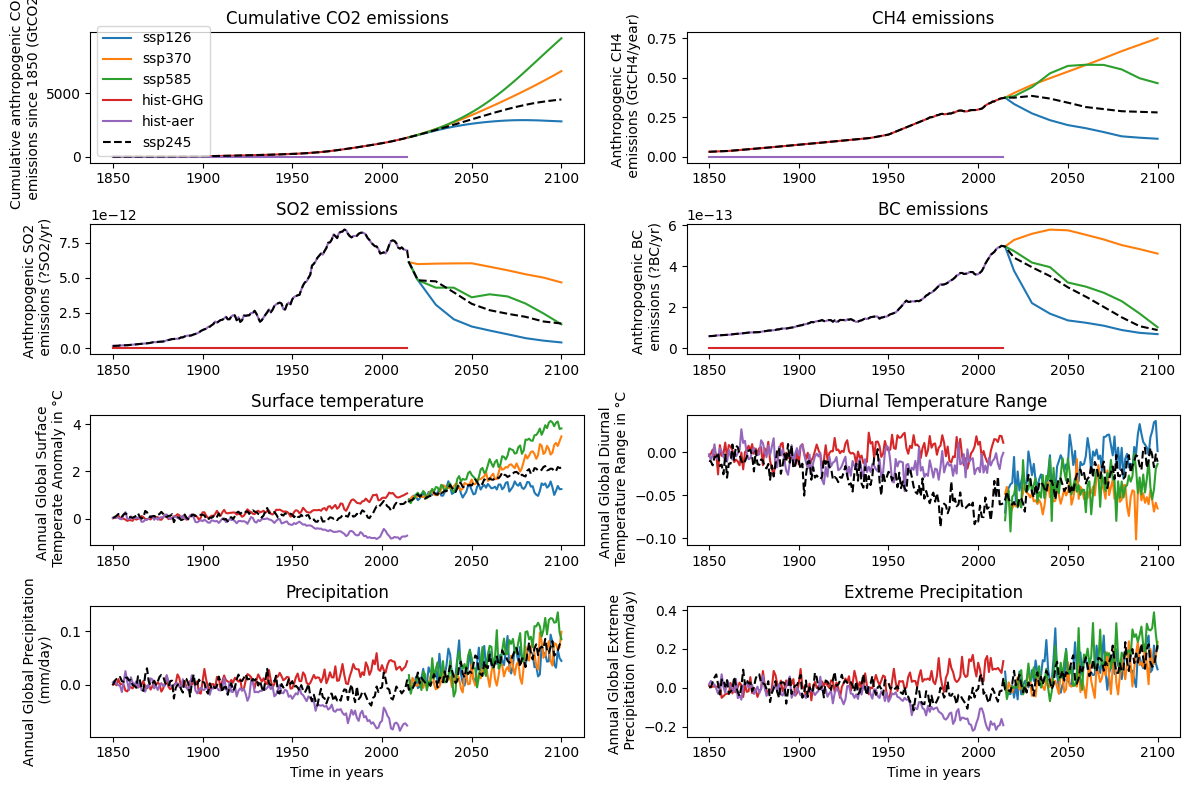

In [7]:
import emcli.utils.plotting as plotting

axs = plotting.plot_all_vars_global_avg(X_train=X_train, 
            X_test=X_test, 
            Y_train=Y_train, 
            Y_test=Y_test,
            scenarios_train=scenarios_train,
            scenarios_test=scenarios_test)

plt.savefig('figures/inputdata_globalmeans.png') # repeat this command below, changing the fig name as you like

As we can see, the ClimateBench dataset contains various greenhouse gases and aerosols that we could use as inputs: cumulative carbon dioxide (co2), methane (ch4), sulfur dioxide (so2), and black carbon (bc). We decide to use the  cumulative co2 emissions as inputs, because they are the strongest signal in the relationship to surface temperatures (see ClimateBench, Appendix). Using only co2 as input, we'll need to be aware that the variation in the other variables (ch4, so2, and bc) will be confounding our predictions.

As possible learning targets, the dataset contains the following 2D variables: surface temperature anomalies, diurnal temperature range, precipitation, and extreme precipitation. 

We decided to use surface temperature in both spatial 2D maps and 1d global means. 

## Data Visualization

First, we plot the target surface temperature map averaged from 2080-2100 from the testing set (the ssp245 scenario). We will use this for validation.

**ATMS559: Include this figure in your write up and describe the characteristics of the data in your write-up in few sentences. Where is warming greatest and least, etc.**

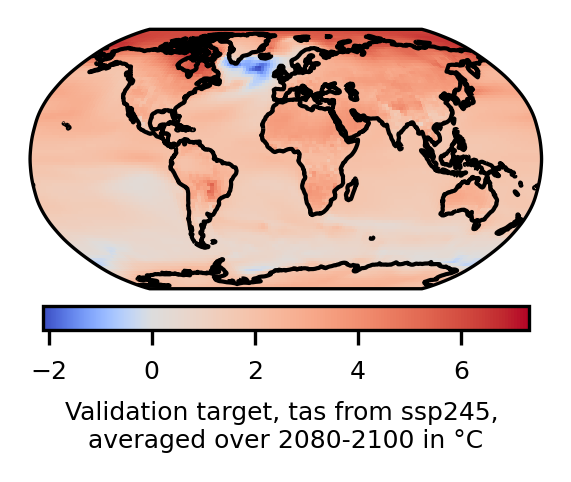

In [8]:
data_var = 'tas'               # surface temperature 
tas_true = Y_test[0][data_var] # true is short for validation

# Compute temporal average of target and prediction to average out
#  internal variability over evaluation timeframe
tas_true_t_avg = tas_true.sel(time=slice("2080", "2100")).mean(dim="time")

# Create figure with PlateCarree projection
projection = ccrs.Robinson(central_longitude=0)
transform = ccrs.PlateCarree(central_longitude=0)
fig, axs = plt.subplots(1, 1, figsize=(2.2, 1.5), 
    subplot_kw=dict(projection=projection),
    dpi=300)
# Plot ground-truth surface temperature anomalies
cnorm = colors.TwoSlopeNorm(vmin=tas_true_t_avg.min(), vcenter=0, vmax=tas_true_t_avg.max()) # center colorbar around zero
mesh = axs.pcolormesh(tas_true.longitude.data, tas_true.latitude.data, 
                         tas_true_t_avg.data, cmap='coolwarm',
                         norm=cnorm, transform=transform)
cbar = plt.colorbar(mesh, ax=axs, orientation='horizontal', shrink=0.95, pad=0.05)
cbar.set_label(f'Validation target, {data_var} from ssp245, \naveraged over 2080-2100 in °C',size=6)
cbar.ax.tick_params(labelsize=6)
cbar.ax.set_xscale('linear')
axs.coastlines()

#plt.savefig('figures/XXXX.png') # uncomment to save a copy of this figure, etc

Next we plot the input variable: cumulative co2 emissions, which recall are annual global-means. 

We include the global mean surface temperature, which has a strong year to year variation that is not visible in the smooth co2 input signal. 

Given that this variability is unpredictable, we do not expect our climate emulator to reproduce this signal. 

**ATMS559: In a few sentences, discuss why we can't expect an emulator to reproduce climate variability, let alone variability that is in sync with the test data**

It is common practice to reduce the internal variability by averaging over all realizations, but our dataset only has three realizations per scenario. So, instead we average over realizations and also take a 20-year average in the validation dataset.

What's more, we can see that the temperature increase is almost a linear function of the cumulative co2 emissions, by creating a scatter plot (right). This relationship seems to brake primarily only for hist-aer, a scenario of historical emissions that withheld co2 emissions. FYI, if you've never seen this kind of plot before, it was a major finding in about 2009, and is a consquence of the carbon cycle drawing down carbon at a rate that offsets delayed warming from past forcing. 

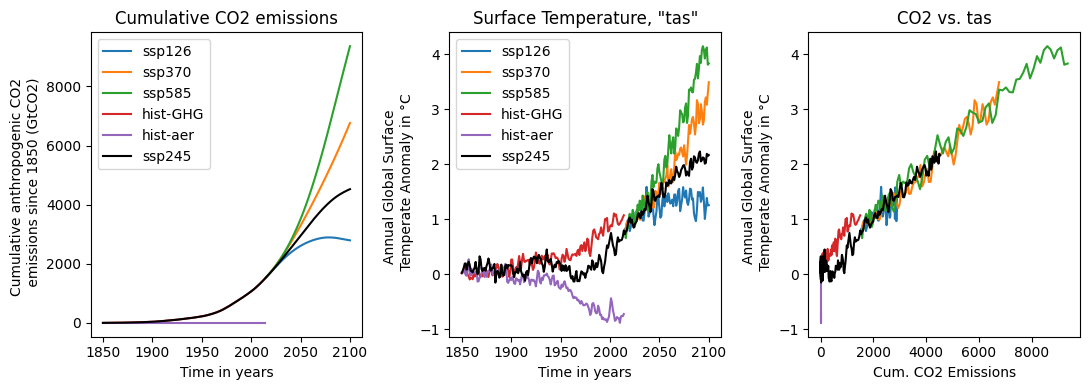

In [9]:
%reload_ext autoreload
%aimport emcli

import emcli.utils.plotting as plotting
from emcli.dataset.climatebench import DATA_VAR_LABELS 
data_var = 'tas'
plotting.plot_co2_data_var_global_over_time(X_train=X_train,
          X_test=X_test, 
          Y_train=Y_train, 
          Y_test=Y_test,
          scenarios_train=scenarios_train,
          scenarios_test=scenarios_test,
          data_var=data_var,
          data_var_labels=DATA_VAR_LABELS);

#plt.savefig('figures/XXXX.png') # uncomment to save a copy of this figure, etc

Most ML models require in-/ and outputs that are normalized to zero-mean and unit variance. We will only fit simple models that don't require normalization.

<a name="methodology"></a>
# Constructing the Linear Emulator Models

Designing the emulator model is a function of data availability, data complexity, and domain knowledge.

**Model complexity:** We can roughly order common ML models by complexity: linear model < random forest < Gaussian Process < CNN, Neural Operator, GNN < LSTM < CNN-LSTM < Transformer.

**Linear baseline:** ClimateBench already implemented a random forest, Gaussian Process, and CNN-LSTM. Especially, the CNN-LSTM, however, is a very complex model with millions to billions of parameters. The creaters of this tutorial hypothesized that there is not sufficient data available to match the CNN-LSTM's model complexity. So, they decided to start by constructing a linear pattern scaling emulator, which assumes local independence, i.e., the temperature at every grid point is independent of the temperature at other grid point. 

The linear pattern scaling emulator is described shortly, but first let's try to emulate the global mean surface temperature field.

### global CO2 -> global tas<a name="linear-co2-to-tas"></a>

This model maps global-averaged cumulative co2 onto the globally-averaged surface temperature by fitting the relationship with linear regression. If you like fancy symbolic math, this looks like: 

- $f_{global}: co2_{global-avg}(t) \in \mathbb{R} \rightarrow tas_{global-avg}(t) \in \mathbb{R}$

Since cumulative emissions increase monotonically in time, the model incorporates time simply from the cumulative emissions input variable. Hence you won't see time enter explicitly into the model construction because it is present via the CO2 variable.

The fit uses all scenarios and times in the training dataset. After training, the model predicts the relationship in the testing scenario. 

**ATMS559: You don't need to know the details of what the code is doing at each step here. Know that it is a fit to a line. Just run the code and be grateful that someone else wrote the code for you. Your job is to focus on the figures and what it all means.**

In [10]:
#@title: fit linear model for global GHGs -> global tas

import emcli.models.pattern_scaling.model as ps
import emcli.dataset.interim_to_processed as i2p

# Convert training data from interim to processed
data_var = 'tas' # 'tas', 'pr'
dir_global_global = data_root + 'interim/global_global/'
input_train, target_train = i2p.interim_to_global_global(
                             X_global_local=X_train, 
                             Y_global_local=Y_train,
                             input_keys=['CO2'],
                             target_keys=[data_var],
                             save_dir=dir_global_global+'train/')

print(target_train.shape)
# Fit Linear regression model from global ghg at t -> global data_var as t
model_lr = ps.fit_linear_regression_global_global(data_dir=dir_global_global+'train/', plot=False)

# Save model
dir_pattern_scaling = './'
model_name = f'global_co2_to_global_{data_var}.pkl'
ps.save(model_lr, dir=dir_pattern_scaling, filename=model_name)

# Convert test data from interim to processed
input_test, target_test = i2p.interim_to_global_global(X_global_local=X_test, # [X_train[2]],# 
                             Y_global_local=Y_test, # [Y_train[2]],#
                             input_keys=['CO2'],
                             target_keys=[data_var],
                             save_dir=dir_global_global+'test/')

# If you want to rerun multiple times, you can simply load the model that you saved. 
# It is commented out now since we just ran it and it is still in memory.
# model_lr = ps.load(dir=dir_pattern_scaling, filename=model_name)

# Apply linear regression model on test data
preds_lr = ps.predict_linear_regression_global_global(model_lr, 
            data_dir=dir_global_global+'test/',
            plot=False)

Saving processed data at:  ./interim/global_global/train/
(588, 1, 1, 1)
Saving processed data at:  ./interim/global_global/test/


**ATMS559: Regarding the figures made next, why does the emulation's ssp245-pred curve fit less well during the 20th century compared to the 21st (hint look at the other forcings in the 20th and 21st centuries in the first figure above).**

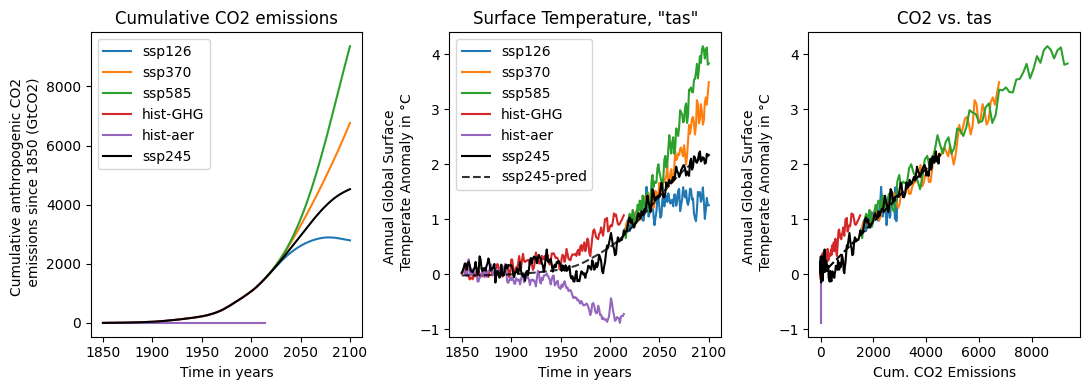

In [11]:
# Plot linear regression predictions with the train and test data

import emcli.utils.plotting as plotting
plotting.plot_co2_data_var_global_over_time(X_train=X_train,
          X_test=X_test, 
          Y_train=Y_train, 
          Y_test=Y_test,
          scenarios_train=scenarios_train,
          scenarios_test=scenarios_test,
          preds=preds_lr,
          data_var=data_var,
          data_var_labels=DATA_VAR_LABELS); 

#plt.savefig('figures/othersummaryplot.png')

### Linear Pattern Scaling Emulator: global tas -> local tas<a name="global-to-local-tas"></a>

Linear pattern scaling also fits the data with linear regression, but it is done per grid cell. This time the predictor is the global mean surface temperature from either the raw ClimateData or the output of the emulator we just constructed (we'll use the latter here, but it doesn't matter much). If you like fancy symbolic math, this looks like: 

- $f_{local}: tas_{global-mean}(t) \in \mathbb{R} \rightarrow tas_{0:lat, 0:lon}(t) \in \mathbb{R}^{(lat, lon)}$

In summary, we take the following assumptions:
  - Global temperature increase is a linear function of global cumulative co2 emissions.
  - Local temperature anomalies are spatially independent, given the global temperature anomaly.  
  - There is no memory. An instant quadrupling of CO2 will result in instant temperature response.

In [12]:
#@title: fit linear pattern scaling model for global tas -> local tas

import emcli
import importlib
importlib.reload(emcli)
#from emcli.models.pattern_scaling.model import PatternScaling
#from emcli.models.pattern_scaling.model import save
import emcli.models.pattern_scaling.model as ps

data_var = 'tas' # 'tas', 'pr', 'pr90'
# Retrieve global temperatures for training as input
var_global = target_train.flatten() # (n_time,)  
# Retrieve annual local temperature field for training as output
var_local = np.concatenate([dataset[data_var].data for dataset in Y_train],axis=0) # (n_time, n_lat, n_lon)

# Initialize and fit pattern scaling model
pattern_scaling = ps.PatternScaling(deg=1)
pattern_scaling.train(var_global, var_local)

# Save model
dir_pattern_scaling = repo_root + 'runs/pattern_scaling/default/models/'
model_name = f'global_tas_to_local_{data_var}.pkl'
ps.save(pattern_scaling, dir=dir_pattern_scaling,filename=model_name)

# Use global tas predictions for ssp245 from previous model as input
var_global_test = preds_lr.flatten() # (n_time,)
# uncomment to use global tas for ssp245 from NorESM2 as input (looks about the same so use the latter)
#var_global_test = target_test.flatten() # (n_time,) 

# If you want to run the model without reconstructing at a later date, just load the model
# pattern_scaling = ps.load(dir=dir_pattern_scaling,filename=model_name)

# Apply pattern scaling model on test data
preds_pattern_scaling = pattern_scaling.predict(var_global_test) # (n_time, n_lat, n_lon)

<a name="results-and-discussion"></a>
# Results & Discussion

## Evaluating Climate Emulators

Evaluating the results of climate emulators is not trivial and not an entirely answered question. Here, we will only use error maps and average NRMSE to analyze our resutls, following ClimateBench.

Below, we can see the validation surface temperature anomaly maps in the test scenario (ssp245), averaged over 2080-2100 (left). The equivalent predicted from the linear model pattern emulator is displayed in the middle. The plot on the right shows the error: prediction - target. 

We can see that the linear model is surprisingly good. 

**ATMS559: Include the next figure in your write-up and describe its accuracy in your own words in a paragraph.**

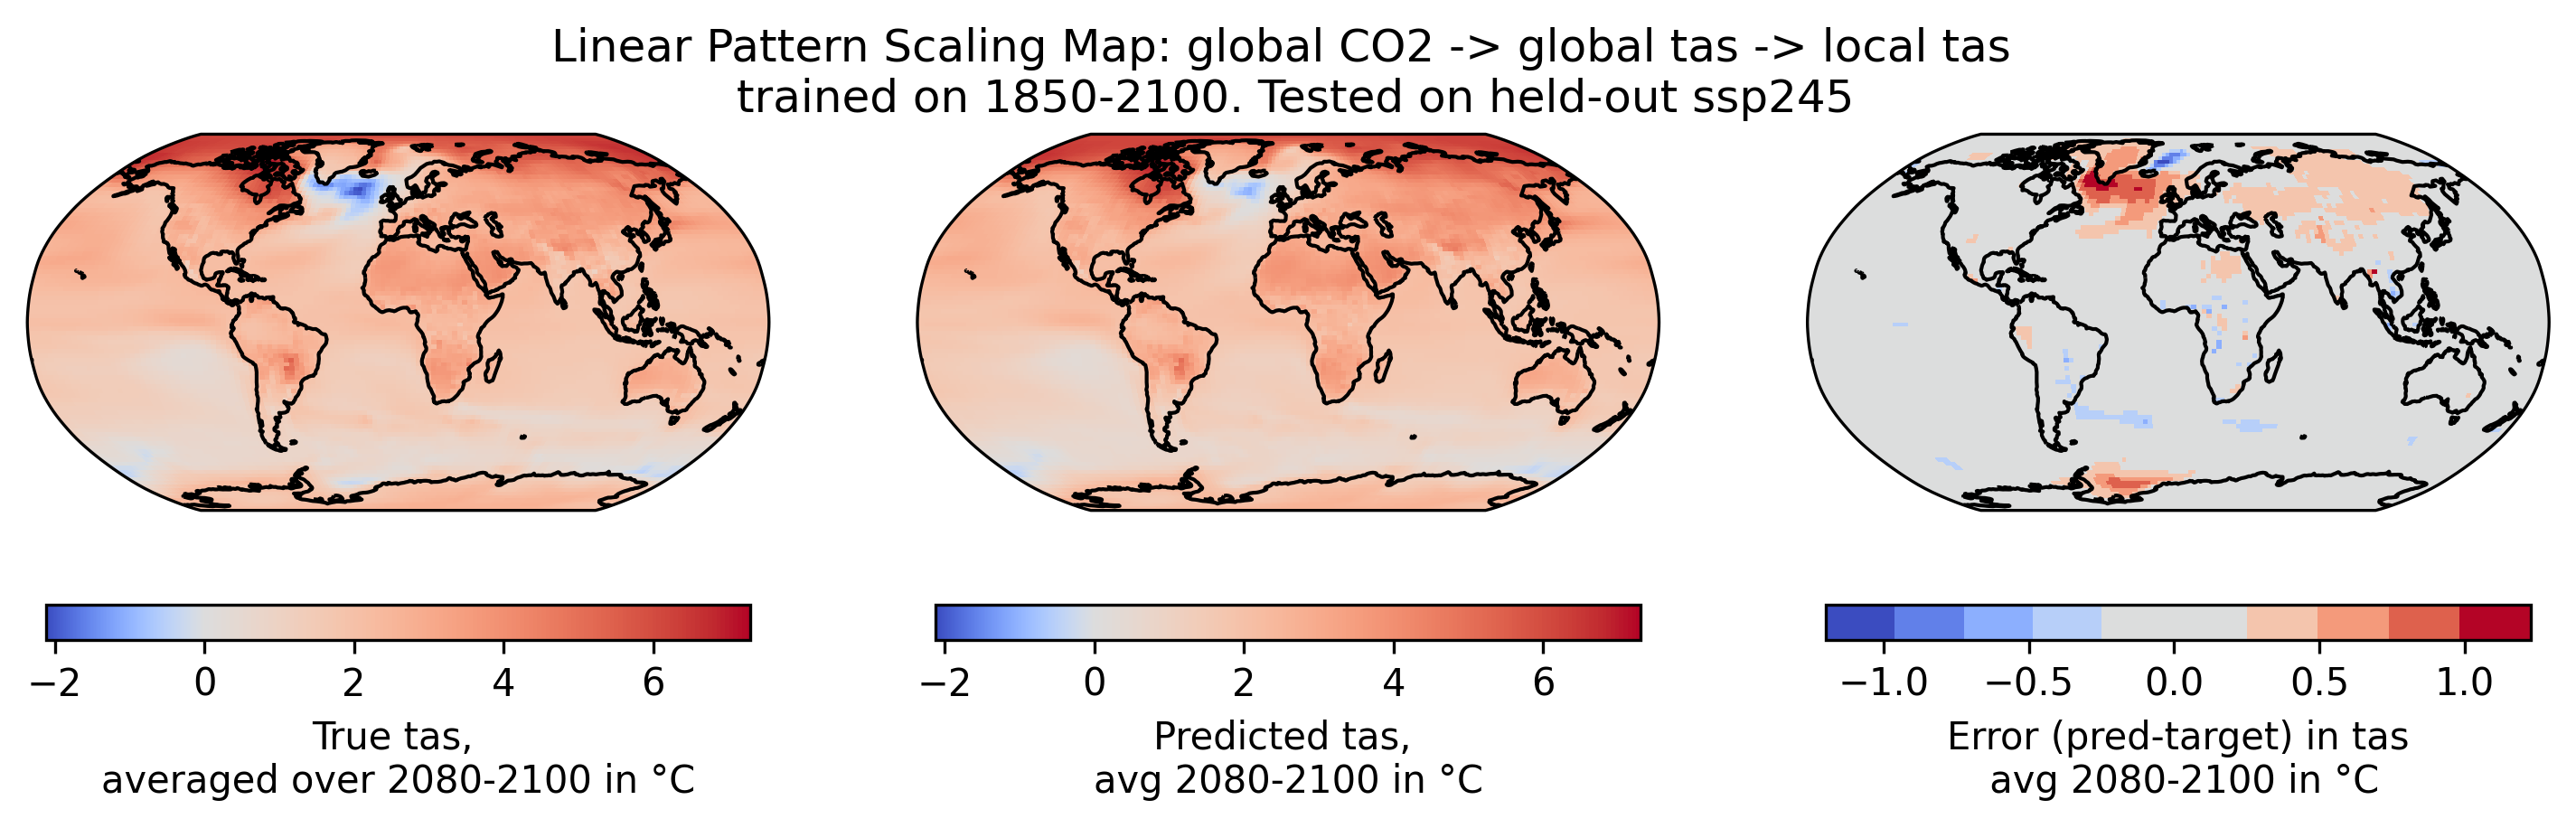

In [13]:
# Plot error map, this takes a few seconds
from emcli.utils.plotting import plot_tas_annual_local_err_map

preds_pattern_scaling_xr = xr.DataArray(data=preds_pattern_scaling, 
    coords=Y_test[0][data_var].coords, name=data_var) # convert predictions into axarray
preds_pattern_scaling_ds = [xr.merge([preds_pattern_scaling_xr])]
axs = plot_tas_annual_local_err_map(Y_test[0][data_var], preds_pattern_scaling_ds[0][data_var], data_var=data_var)
axs[1].set_title(f'Linear Pattern Scaling Map: global CO2 -> global tas -> local {data_var} \n trained on 1850-2100. Tested on held-out {scenarios_test[0]}')
plt.show()

To compare across models, we calculate the normalized root mean square error (NRMSE). To evaluate spatial accuracy, the NRMSE first calculates the MSE per grid cell and then calculates the global average instead of vice versa.

In [14]:
#from xskillscore import rmse
from emcli.utils.metrics import calculate_nrmse

Y_nrmse = calculate_nrmse(Y_true=Y_test[0][data_var], Y_pred=preds_pattern_scaling_ds[0][data_var])
print(Y_nrmse)

0.07832496942108064


### CNN-LSTM: Comparison with a large deep learning model<a name="cnn-lstm"></a>

We now compare the linear pattern scaling model with the CNN-LSTM model in ClimateBench. The CNN-LSTM was trained and tested on the same dataset. However, CNN-LSTM uses globally-averaged methane (ch4), local maps of sulfur dioxide (so2), and local maps of black carbon (bc) as additional inputs. Further, the CNN-LSTM is trained and tested on time-intervals of length 10 years. The comparison between CNN-LSTM and our linear pattern scaling model is still fair, because the data in the linear pattern scaling is a strict subset of the CNN-LSTM data. In summary, the linear pattern scaling and CNN-LSTM models were trained on the following mapping:

- $f_{linear}: co2_{global-avg}(t) \in \mathbb{R} \rightarrow tas_{0:lat, 0:lon}(t) \in \mathbb{R}^{(lat, lon)}$
- $f_{cnn-lstm}: [co2_{global-avg}(t{-}10{:}t), ch4_{global-avg}(t{-}10{:}t), so2_{0:lat, 0:lon}(t{-}10{:}t), bc_{0:lat, 0:lon}(t{-}10{:}t)] \in \mathbb{R}^{10} \times \mathbb{R}^{10} \times \mathbb{R}^{(lat,lon,10)} \times \mathbb{R}^{(lat,lon,10)} $
    $\rightarrow tas_{0:lat, 0:lon}(t) \in \mathbb{R}^{(lat, lon)}$

Further details on the CNN-LSTM model are described in the ClimateBench paper.

Now, we compare the accuracy of CNN-LSTM vs. Linear Pattern Scaling. First, we plot the error maps (sourced from Fig. 4 and Fig. A2 in the ClimateBench). We can see that the CNN-LSTM has comparitively little error in the North Atlantic Warming Hole, Weddel Sea, and Greenland Sea. Therefore, the CNN-LSTM has a substantial bias to over (under-) predict warming in the Northern (Southern) hemisphere, respectively. From the error plots, it seems like the Linear Pattern Scaling model and CNN-LSTM model have complementary errors.

Surprisingly the NRMSE of the CNN-LSTM is 0.107, which is higher than the Linear Pattern Scaling NRMSE of 0.080. This indicates our hypothesis that there was not sufficient data available for the model complexity of the CNN-LSTM was likely true.

**ATMS559: Include the next figure in your write-up and describe its accuracy in your own words in a paragraph.**
You won't run this model. Instead, check out this saved figure.

![ClimateBench CNN-LSTM](figures/climatebench.png)

## Data vs. model complexity: Polynomial Pattern Scaling<a name="polynomial-pattern-scaling"></a>
The fact that a linear model outperforms a large deep learning model brings us to the question if more complex models are necessary at all or if a linear model is just fine, for this task? Here, we saw that a linear model achieves most of the accuracy. Nevertheless, we learned that the data is not entirely linear, e.g., in the Arctic. To find the best model complexity, we're demonstrating a new plot: Performance vs. model complexity. If the best performing model is one with low complexity we know that our task is likely not very complex or inherently data limited. 

To plot performance vs. model complexity we slightly modify the Linear Pattern Scaling model from above. Instead of fitting a linear curve to every grid cell, we are now fitting a polynomial of degree (or order) n to each grid cell. Every grid cell has the same polynomial degree, but coefficients that are independent of the other grid cells. The model complexity is determinded by the polynomial degree.

In [15]:
## Find best polynomial degree in nonlinear pattern scaling that fits the data
# Initialize and fit pattern scaling model, takes a minute or two

degrees = np.arange(1,23)
Y_nrmse_over_degree_train1850to2100 = []
Y_nrmse_over_degree_train2080to2100 = []

for degree in degrees:
    pattern_scaling_poly = ps.PatternScaling(deg=degree)
    pattern_scaling_poly.train(var_global, var_local)

    Y_nrmse = [] # list of nrmse for each train scenario
    Y_nrmseonly = [] # list of nrmse for 1981-2100 only for each train scenario
    for scenario_idx in range(3):  # only test/evaluate the ssp data
        # Get global average 'tas' as inputs to pattern scaling
        #  Not taking data_var, because most data_var are linearly correlated to 
        #  globally-averaged tas, but not to global data_var.
        #  Technically, we should use linear co2-> global tas predictions here,
        #  but this is a little easier and it doesn't seem like it should matter.
        _, tas_train = i2p.interim_to_global_global(
                                    X_global_local=X_train[scenario_idx:scenario_idx+1],
                                    Y_global_local=Y_train[scenario_idx:scenario_idx+1],
                                    input_keys=['CO2'],
                                    target_keys=['tas'],
                                    save_dir=None)
        tas_global = tas_train.flatten() # (n_time,)

        # Apply pattern scaling model on train data; using train as validation set
        preds_pattern_scaling_poly = pattern_scaling_poly.predict(tas_global) # (n_time, n_lat, n_lon)

        # Convert into xarray
        preds_pattern_scaling_poly_xr = xr.DataArray(data=preds_pattern_scaling_poly, 
            coords=Y_train[scenario_idx]['tas'].coords, name='tas') # convert predictions into axarray
        preds_pattern_scaling_poly_ds = [xr.merge([preds_pattern_scaling_poly_xr])]

        # Calculate NRMSE over all years in train set
        nrmse = calculate_nrmse(Y_true=Y_train[scenario_idx]['tas'], Y_pred=preds_pattern_scaling_poly_ds[0]['tas'],avg_only_over_last_20_yrs=False)
        nrmseonly = calculate_nrmse(Y_true=Y_train[scenario_idx]['tas'], Y_pred=preds_pattern_scaling_poly_ds[0]['tas'])
        Y_nrmse.append(nrmse)
        Y_nrmseonly.append(nrmseonly)
    Y_nrmse = np.mean(Y_nrmse)
    Y_nrmseonly = np.nanmean(Y_nrmseonly)
    Y_nrmse_over_degree_train1850to2100.append([degree, Y_nrmse])
    Y_nrmse_over_degree_train2080to2100.append([degree, Y_nrmseonly])

Y_nrmse_over_degree_train1850to2100 = np.transpose(np.array(Y_nrmse_over_degree_train1850to2100))
Y_nrmse_over_degree_train2080to2100 = np.transpose(np.array(Y_nrmse_over_degree_train2080to2100))

/glade/work/bitz/ATMS559-climate-emulator-tutorial/emcli/models/pattern_scaling/model.py:46: RankWarning: Polyfit may be poorly conditioned
  self.coeffs = np.polyfit(in_global, out_local, deg=self.deg) # (2, n_lat*n_lon)


In [16]:
## Find best polynomial degree in nonlinear pattern scaling that fits the data
# Initialize and fit pattern scaling model, takes a minute or two

degrees = np.arange(1,23)
Y_nrmse_over_degree_test1850to2100 = []
Y_nrmse_over_degree_test2080to2100 = []

for degree in degrees:
    pattern_scaling_poly = ps.PatternScaling(deg=degree)
    pattern_scaling_poly.train(var_global, var_local)

    # Apply pattern scaling model on test data
    preds_pattern_scaling_poly = pattern_scaling_poly.predict(var_global_test) # (n_time, n_lat, n_lon)

    # Convert into xarray
    preds_pattern_scaling_poly_xr = xr.DataArray(data=preds_pattern_scaling_poly, 
        coords=Y_test[0][data_var].coords, name=data_var) # convert predictions into axarray
    preds_pattern_scaling_poly_ds = [xr.merge([preds_pattern_scaling_poly_xr])]

    # Calculate NRMSE
    Y_nrmse = calculate_nrmse(Y_true=Y_test[0][data_var], Y_pred=preds_pattern_scaling_poly_ds[0][data_var],avg_only_over_last_20_yrs=False)
    Y_nrmse_over_degree_test1850to2100.append([degree, Y_nrmse])

    Y_nrmse = calculate_nrmse(Y_true=Y_test[0][data_var], Y_pred=preds_pattern_scaling_poly_ds[0][data_var])
    Y_nrmse_over_degree_test2080to2100.append([degree, Y_nrmse])
    
Y_nrmse_over_degree_test1850to2100 = np.transpose(np.array(Y_nrmse_over_degree_test1850to2100))
Y_nrmse_over_degree_test2080to2100 = np.transpose(np.array(Y_nrmse_over_degree_test2080to2100))

/glade/work/bitz/ATMS559-climate-emulator-tutorial/emcli/models/pattern_scaling/model.py:46: RankWarning: Polyfit may be poorly conditioned
  self.coeffs = np.polyfit(in_global, out_local, deg=self.deg) # (2, n_lat*n_lon)


**ATMS559: Include the next two figures in your write-up and describe them in your own words in a paragraph or two.**

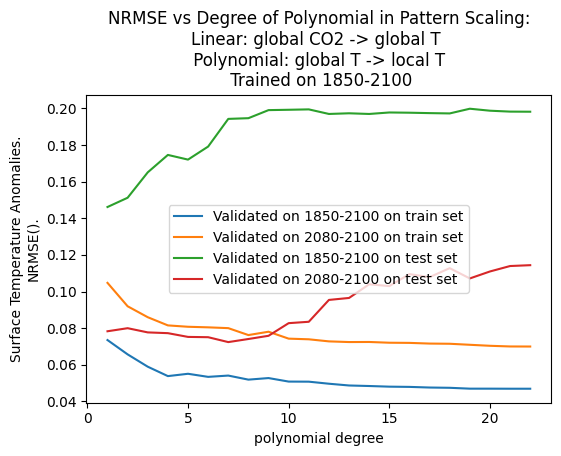

In [17]:
# Plot NRMSE over polynomial degree
fig, axs = plt.subplots(1,1, figsize =(6,4))
axs.plot(Y_nrmse_over_degree_train1850to2100[0,:], Y_nrmse_over_degree_train1850to2100[1,:],label='Validated on 1850-2100 on train set')
axs.plot(Y_nrmse_over_degree_train2080to2100[0,:], Y_nrmse_over_degree_train2080to2100[1,:],label='Validated on 2080-2100 on train set')
axs.plot(Y_nrmse_over_degree_test1850to2100[0,:], Y_nrmse_over_degree_test1850to2100[1,:],label='Validated on 1850-2100 on test set')  # TAKE ME OUT MAYBE
axs.plot(Y_nrmse_over_degree_test2080to2100[0,:], Y_nrmse_over_degree_test2080to2100[1,:],label='Validated on 2080-2100 on test set')  # TAKE ME OUT MAYBE
axs.set_xlabel('polynomial degree')
axs.set_ylabel('Surface Temperature Anomalies.\nNRMSE().')
axs.set_title(f'NRMSE vs Degree of Polynomial in Pattern Scaling:\nLinear: global CO2 -> global T \n Polynomial: global T -> local T \n Trained on 1850-2100');
axs.legend()

#### Polynomial pattern scaling: global tas -> local tas

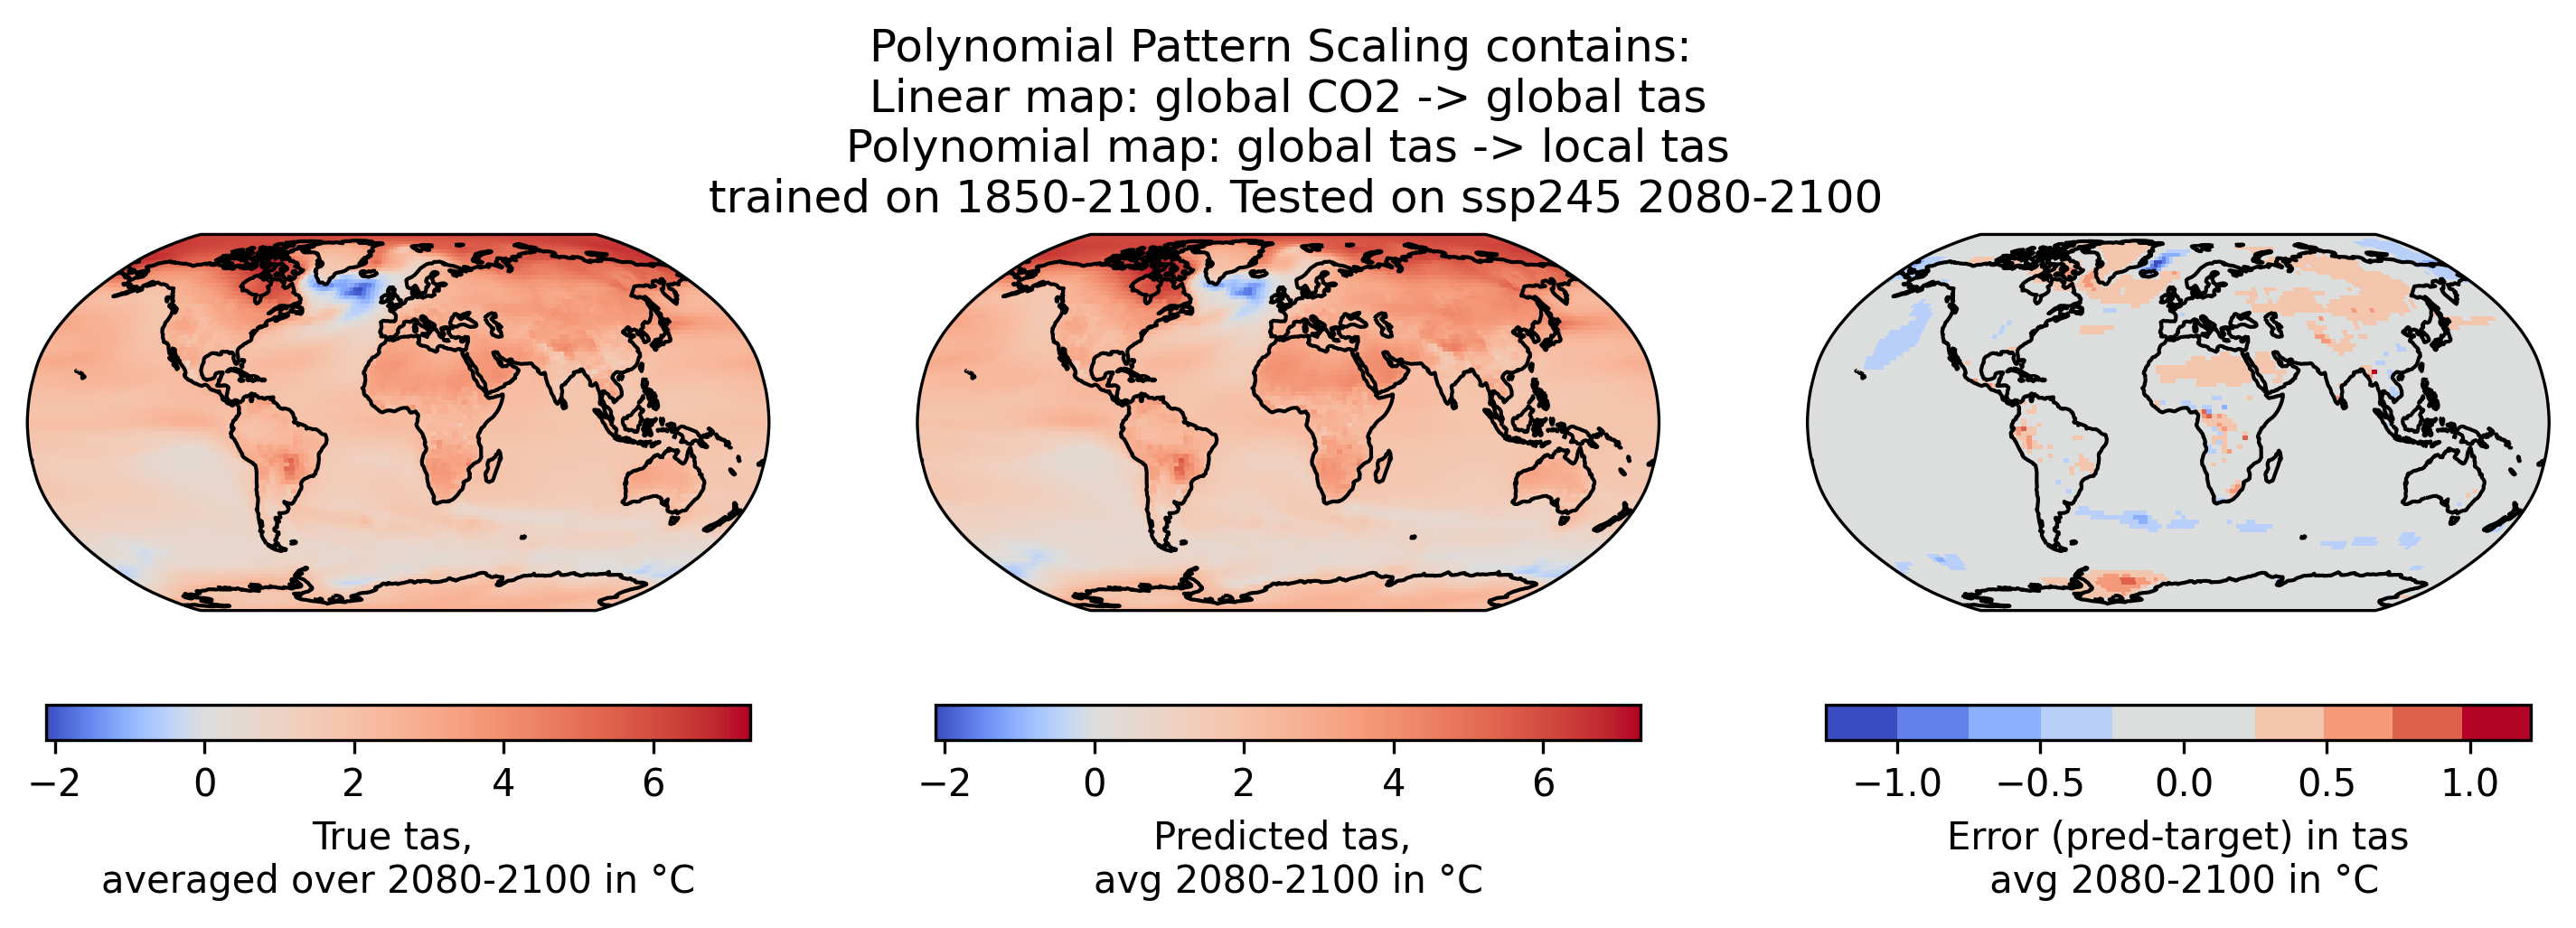

degree:	7:	 NRMSE:0.07241152188072221


In [18]:
# Train polynomial pattern scaling model.
    
# let's plot the degree 7 model just to see how it looks for the 2080-2100 test validation period
degree = 7
pattern_scaling_poly = ps.PatternScaling(deg=degree)
pattern_scaling_poly.train(var_global, var_local)

# Apply pattern scaling model on test data
preds_pattern_scaling_poly = pattern_scaling_poly.predict(var_global_test) # (n_time, n_lat, n_lon)

# Convert into xarray
preds_pattern_scaling_poly_xr = xr.DataArray(data=preds_pattern_scaling_poly, 
    coords=Y_test[0][data_var].coords, name=data_var) # convert predictions into axarray
preds_pattern_scaling_poly_ds = [xr.merge([preds_pattern_scaling_poly_xr])]

# Plot error map
axs = plot_tas_annual_local_err_map(Y_test[0][data_var], preds_pattern_scaling_poly_ds[0][data_var], data_var=data_var)
axs[1].set_title(f'Polynomial Pattern Scaling contains: \n Linear map: global CO2 -> global tas \n Polynomial map: global tas -> local {data_var} \n trained on 1850-2100. Tested on {scenarios_test[0]} 2080-2100')
plt.show()

# Calculate NRMSE
Y_nrmse = calculate_nrmse(Y_true=Y_test[0][data_var], Y_pred=preds_pattern_scaling_poly_ds[0][data_var])
print(f'degree:\t{degree}:\t NRMSE:{Y_nrmse}')

The above plot shows a number of important lessons. 

**ATMS559: Discuss the following in your write-up:**

(1) Increasing model complexity can indeed improve the apparent performance of our model. Why?

(2) We never converge on the best degree when validating with the training data, regardless of validation period. Why?

(3) We come to different conclusions about the best fit from the test data, regardless of validation period. Why?

(4) The emulator we constructed here employs a simple polynomial fit with one "hyperparameter", which is the degree of the polynomial (plus all associated coefficients). Neural networks with many hyperparameters likely overfit even worse. Would a dataset with more scenarios and/or less internal variability be easier to emulate?

(5) Is it possible that the model could be further improved by customizing the emulator depending on the region?


# Conclusion<a name="conclusion"></a>

## Summary

From the authors: To summarize, we have seen that one can emulate the relationship between co2 emissions and local temperature by using a linear model. Surprisingly, the linear model outperforms deep learning models on this task. This underlines the importance of starting simple: whenever we'd like to show that large ML models are good for something it's good to start with a linear model. Further, using ML needs a rigorous description of train/validation/test splits to avoid overfitting on spurious correlations or internal variability. Lastly, there's 20PB in the CMIP6 data and it is a significant effort to select the in-/output variables that are most interesting for research. Here, we conclude that ML research might be an overkill for emulating annually-averaged mean surface temperature anomalies and think that it might be better suited for emulating more complex variables, such as local aerosols or extreme value statistics. 

# References<a name="references"></a>

Please cite this abstract if you consider this tutorial useful:

```

@misc{lutjens23climatetutorial,
    author = {Lütjens, Björn and Hadzic, Lea M. and Newman, Dava and Veillette, Mark},
    publisher = {AGU23 Fall Meeting},
    title={The Climate Pocket: Tutorial on Building Fast Emulators in Climate Modeling},
    year={2023},
    url={https://agu.confex.com/agu/fm23/meetingapp.cgi/Paper/1304372}}

```2021MS002954.



Other References

*   Lütjens, B. et al. (2022). Multiscale Neural Operator: Learning Fast and Grid-independent PDE Solvers, arXiv,  
https://doi.org/10.48550/arXiv.2207.11417.

*   O'Neill, B. C. et al. (2022). The Scenario Model Intercomparison Project (ScenarioMIP) for CMIP6. Geosci. Model Dev., 9, 3461–3482, https://doi.org/10.5194/gmd-9-3461-2016.

*   Tebaldi, C. et al. (2021). Climate model projections from the Scenario Model Intercomparison Project (ScenarioMIP) of CMIP6, EGU ESD, https://doi.org/10.5194/esd-12-253-2021.

*   Watson-Parris, D. et al. (2022). ClimateBench v1.0: A Benchmark for Data-Driven Climate Projections. Journal of Advances in Modeling Systems, 14(10), https://doi.org/10.1029/2021MS002954.

